<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/001_Correlations_and_Significance_of_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/01_Correlations_and_Significance_of_Features.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 📉 Tutorial: Korelacja, Chi-Kwadrat i Istotność Cech

W Data Science nie każda kolumna w tabeli jest ważna. Często mamy "śmieciowe" dane (szum), które tylko mylą model.
Jak sprawdzić, co jest ważne? Zależy to od **typu danych**.

W tym notatniku nauczysz się 3 kluczowych metod:
1.  **Korelacja Pearsona:** Gdy badasz Liczbę vs Liczbę (np. Metraż a Cena).
2.  **Test Chi-Kwadrat:** Gdy badasz Kategorię vs Kategorię (np. Płeć a Wybór Marki).
3.  **Feature Importance (z modelu):** Metoda "brutalna siła", która mówi, co było ważne dla algorytmu (np. Lasu Losowego).

In [1]:
# Import niezbędnych bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Ustawienia estetyczne
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Biblioteki gotowe. Generujemy dane...")

Biblioteki gotowe. Generujemy dane...


## KROK 1: Generowanie Danych (Laboratorium)

Stworzymy zestaw danych o nieruchomościach, w którym **znamy prawdę**:
1.  **Cena** zależy liniowo od **Metrażu** (Silna korelacja).
2.  **Typ Budynku** (Dom/Blok) zależy od **Dzielnicy** (Zależność kategoryczna).
3.  **Kolor Ścian** jest kompletnie losowy (Szum - nieistotny).

In [3]:
np.random.seed(42)
n = 500

# 1. Dane Liczbowe (Metraż -> Cena)
metraz = np.random.randint(30, 150, n)
# Cena to metraż * cena_za_metr + losowy szum
cena = metraz * 9000 + np.random.normal(0, 50000, n)

# 2. Dane Kategoryczne (Dzielnica -> Typ Budynku)
dzielnica = np.random.choice(['Centrum', 'Przedmieścia'], n)
typ_budynku = []

for d in dzielnica:
    if d == 'Centrum':
        # W centrum 90% to Bloki
        typ_budynku.append(np.random.choice(['Blok', 'Dom'], p=[0.9, 0.1]))
    else:
        # Na przedmieściach 80% to Domy
        typ_budynku.append(np.random.choice(['Blok', 'Dom'], p=[0.2, 0.8]))

# 3. Dane Losowe (Szum)
kolor_scian = np.random.choice(['Biały', 'Beżowy', 'Szary'], n)

# Składamy DataFrame
df = pd.DataFrame({
    'Metraż': metraz,
    'Cena': cena,
    'Dzielnica': dzielnica,
    'Typ_Budynku': typ_budynku,
    'Kolor_Ścian': kolor_scian # To jest nasza pułapka (szum)
})

print("Próbka danych:")
display(df.head())

Próbka danych:


,Metraż,Cena,Dzielnica,Typ_Budynku,Kolor_Ścian
0,132,1.189197e+06,Centrum,Blok,Beżowy
1,81,7.725957e+05,Centrum,Dom,Szary
2,122,1.169868e+06,Przedmieścia,Dom,Beżowy
3,44,3.963653e+05,Przedmieścia,Dom,Beżowy
4,136,1.290544e+06,Centrum,Dom,Beżowy


## Metoda 1: Korelacja Pearsona (Liczba vs Liczba)

Stosujemy, gdy chcemy sprawdzić związek liniowy między dwiema liczbami.
Wynik jest z przedziału **[-1, 1]**:
*   `1.0`: Idealna zależność (jedno rośnie, drugie rośnie).
*   `0.0`: Brak zależności (totalny chaos).
*   `-1.0`: Odwrotna zależność (jedno rośnie, drugie maleje).

Macierz korelacji:
          Metraż      Cena
Metraż  1.000000  0.986797
Cena    0.986797  1.000000
------------------------------


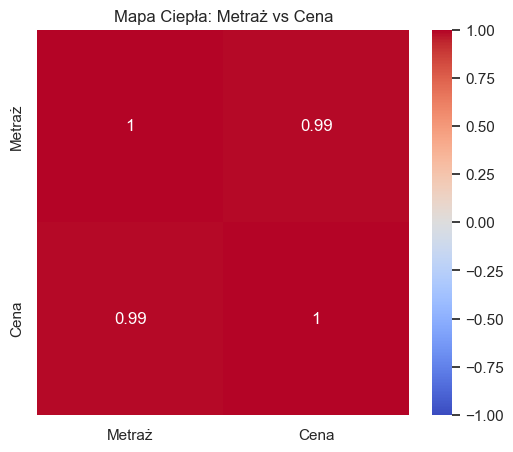

Współczynnik Pearsona: 0.9868 (Bardzo silny związek!)


In [4]:
# Obliczamy korelację między Metrażem a Ceną
corr_matrix = df[['Metraż', 'Cena']].corr()

print("Macierz korelacji:")
print(corr_matrix)
print("-" * 30)

# Wizualizacja (Heatmapa)
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa Ciepła: Metraż vs Cena")
plt.show()

# Sprawdźmy korelację ręcznie
r, _ = pearsonr(df['Metraż'], df['Cena'])
print(f"Współczynnik Pearsona: {r:.4f} (Bardzo silny związek!)")

## Metoda 2: Test Chi-Kwadrat (Kategoria vs Kategoria)

Pearson nie zadziała na tekst. Nie możesz policzyć korelacji między "Centrum" a "Blokiem".
Tutaj wchodzi **Chi-Kwadrat**.

Badamy: **Czy Dzielnica ma wpływ na Typ Budynku?**
Patrzymy na **p-value**:
*   `p < 0.05`: Zależność jest istotna (to nie przypadek).
*   `p > 0.05`: Brak zależności (to czysty przypadek).

In [5]:
# 1. Tworzymy tabelę krzyżową (contingency table)
tabela = pd.crosstab(df['Dzielnica'], df['Typ_Budynku'])

print("Ile budynków gdzie stoi?")
print(tabela)
print("-" * 30)

# 2. Wykonujemy test Chi-Kwadrat
chi2, p, dof, expected = chi2_contingency(tabela)

print(f"Statystyka Chi2: {chi2:.2f}")
print(f"P-value: {p:.10f}") # Zapis dziesiętny

if p < 0.05:
    print("✅ WNIOSEK: Istnieje silna zależność! Lokalizacja wpływa na typ budynku.")
else:
    print("❌ WNIOSEK: Brak zależności.")
    
# Sprawdźmy dla Koloru Ścian (powinno wyjść brak zależności)
tabela_szum = pd.crosstab(df['Dzielnica'], df['Kolor_Ścian'])
_, p_szum, _, _ = chi2_contingency(tabela_szum)
print(f"\nP-value dla koloru ścian: {p_szum:.4f} (Prawdopodobnie > 0.05, czyli brak związku)")

Ile budynków gdzie stoi?
Typ_Budynku   Blok  Dom
Dzielnica              
Centrum        240   28
Przedmieścia    48  184
------------------------------
Statystyka Chi2: 238.64
P-value: 0.0000000000
✅ WNIOSEK: Istnieje silna zależność! Lokalizacja wpływa na typ budynku.

P-value dla koloru ścian: 0.7084 (Prawdopodobnie > 0.05, czyli brak związku)


## Metoda 3: Feature Importance (Las Losowy)

Co jeśli masz mieszane dane? I liczby, i tekst? I nieliniowe zależności?
Najlepiej wrzucić wszystko do modelu drzewiastego (np. **Random Forest**).

Model podczas nauki sam oceni, które kolumny były mu najbardziej potrzebne do zgadywania wyniku.
Tutaj naszym celem (Target) będzie **Typ_Budynku**. Zobaczymy, czy model wykryje, że "Kolor Ścian" jest bezużyteczny.

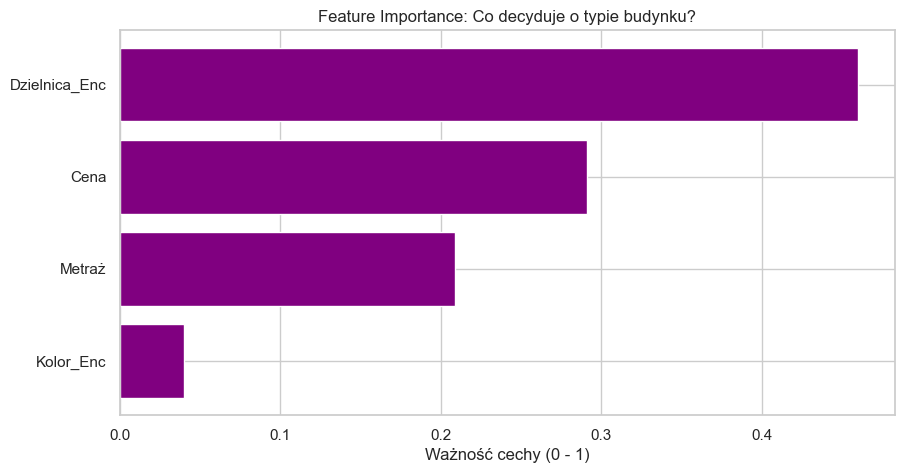

In [6]:
# Przygotowanie danych dla modelu
df_model = df.copy()

# Zamieniamy tekst na liczby (Label Encoding)
le = LabelEncoder()
df_model['Dzielnica_Enc'] = le.fit_transform(df_model['Dzielnica'])
df_model['Kolor_Enc'] = le.fit_transform(df_model['Kolor_Ścian'])
# Cel: 0 = Blok, 1 = Dom
y = le.fit_transform(df_model['Typ_Budynku']) 

# Cechy (X) - usuwamy to, co przewidujemy
X = df_model[['Metraż', 'Cena', 'Dzielnica_Enc', 'Kolor_Enc']]

# Trenujemy Las Losowy
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Pobieramy ważność cech
importances = rf.feature_importances_
cechy = X.columns

# Wizualizacja
plt.figure(figsize=(10, 5))
# Sortujemy dla lepszego wyglądu
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [cechy[i] for i in indices])
plt.xlabel('Ważność cechy (0 - 1)')
plt.title('Feature Importance: Co decyduje o typie budynku?')
plt.show()

## 🧠 Interpretacja wyników

1.  **Dzielnica_Enc:** Powinna być bardzo ważna (długi pasek). Tak zaprojektowaliśmy dane.
2.  **Metraż / Cena:** Mogą mieć pewne znaczenie (domy są zazwyczaj większe i droższe niż mieszkania), model to wyłapał!
3.  **Kolor_Enc:** Powinien być na samym dole (krótki pasek). Model "zorientował się", że kolor ścian nie ma znaczenia przy zgadywaniu typu budynku.

### Zadanie Domowe
Dodaj do DataFrame nową kolumnę `Losowa_Liczba = np.random.rand(n)`.
Uruchom ponownie **Pearsona** (dla Ceny) i **Feature Importance**. Sprawdź, czy metody poprawnie zignorują tę kolumnę.